In [1]:
import qiskit as qiskit
import numpy as np
from random import randint
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit import IBMQ
IBMQ.save_account('7e245f54848bdbcc6bedd42fcafcd2fbe8f81b765b2537e32d39f812c3ccc2e9c755a6ac3e3edc7529982f02954bff4b84cba76cef7fe71928b9f01b092feedf')
IBMQ.load_account()
from qiskit.providers.aer.noise import NoiseModel
import copy
import pandas as pd
import keras
from keras.layers import Dense, LSTM, Dropout, GRU, TimeDistributed, Bidirectional
from keras.models import Sequential
from keras.regularizers import l1, l2, l1_l2
from keras.constraints import max_norm
import matplotlib.pyplot as plt

configrc.store_credentials:WARNING:2020-06-29 19:51:03,126: Credentials already present. Set overwrite=True to overwrite.
Using TensorFlow backend.
/Users/keshavkapoor/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/keshavkapoor/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/keshavkapoor/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be under

# Creating Random Circuits

We want to create random circuits to train and validate our neural network on. To do this, we utilize random number generators with a limit on the circuit depth of the largest quantum computer available to us from the IBMQ Experience, 15 qubits. We want two things from this function:
1. Output a QuantumCircuit object that we can later run on multiple backends
2. Output the data in a way that our neural network can understand:
    * A list which has the following Dimensions: number of qubits x circuit depth
    * Each element in the list will correspond to a gate given by the dictionary `operators`

In [2]:
def create_circuit():
    """This function takes no inputs and outputs a random circuit in neural network representation 
    as well as a quantum circuit object"""
    num_qubits = randint(2,5) #Set the circuit width
    len_circuit = randint(10,30) #Set the circuit depth
    circ = np.zeros((num_qubits,len_circuit)) #Initialize the circuit representation for the Neural Net
    qc = qiskit.QuantumCircuit(num_qubits) #Initialize the actual quantum circuit
    operators = {0:qc.id,1:qc.x,2:qc.y,3:qc.z,4:qc.h,5:qc.cx,6:qc.swap} #Define the operators and their corresponding Neural Net representations
    for i in range(len_circuit):
        num_gates = randint(0,num_qubits-1)
        gates = []
        ctrls = []
        for j in range(num_gates):
            if j != num_gates-1:
                gates.append(randint(0,4))
                ctrls.append(j)
            elif num_gates != num_qubits:
                gates.append(randint(0,6))
                ctrls.append(j)
                targ = randint(num_gates,num_qubits-1) #Choose a target qubit for a 2 qubit gate to act on
        for j,gate_num in enumerate(gates):
            try:
                #Implement the gate if it is a single qubit gate and add it to the neural net representation
                operators.get(gate_num)(ctrls[j]) 
                circ[ctrls[j]][i] = gate_num
            except:
                try:
                    #Implement the gate if it is a 2 qubit gate and add it to the neural net representation
                    operators.get(gate_num)(ctrls[j],targ)
                    circ[ctrls[j]][i] = gate_num
                    circ[targ][i] = gate_num
                except:
                    gate_num = randint(1,6)
    qc.measure_all()
    return circ, qc

In [3]:
def list_of_circuits(num_of_circuits):
    circuits = [0]*num_of_circuits #initialize list by number of desired circuits
    circuit_arrays = [0]*num_of_circuits #initialize list by number of desired circuits

    for i in range(num_of_circuits): 
        #calls create_circuits function desired number of times and puts objects into the arrays
        circuit_arrays[i], circuits[i] = create_circuit()
    return circuit_arrays, circuits

# Creating the Validation Answer Key

Here we use the KL divergence: $D_{KL}(P||Q) = \sum_{x\in\chi} P(x)log\left(\frac{P(x)}{Q(x)}\right)$, to analyze which probability distribution obtained from running our circuit on multiple different backends is the closest to the circuit result obtained from running on a simulator with no noise. We save this data in a list of lists, where each row can be thought of as referencing a circuit and each column can be thought of as referencing a backend (One Hot Encoding). 

In [4]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [5]:
num_circuits = 2000
circuit_arrays, circuits = list_of_circuits(num_circuits)
list_of_backends = IBMQ.get_provider('ibm-q').backends()
list_of_backends.remove(IBMQ.get_provider('ibm-q').get_backend('ibmq_qasm_simulator'))
simulator = Aer.get_backend('qasm_simulator')

validation_set = np.zeros((len(circuits),len(list_of_backends)))
shots = 10000
for i in range(len(circuits)):
    previous_divergence = 1
    best_backend = 0;
    for j in range(len(list_of_backends)):
        if np.shape(circuit_arrays[i])[0] < list_of_backends[j].configuration().num_qubits:
            coupling_map = list_of_backends[j].configuration().coupling_map
            basis_gates = list_of_backends[j].configuration().basis_gates
            noise_model = NoiseModel.from_backend(list_of_backends[j])
            psi_0 = execute(circuits[i], simulator, shots = shots, coupling_map = coupling_map, basis_gates = basis_gates, optimization_level = 3).result().get_counts()
            psi_1 = execute(circuits[i], simulator, shots = shots, coupling_map = coupling_map, basis_gates = basis_gates, noise_model = noise_model, optimization_level = 3).result().get_counts()
            
            psi_00 = copy.deepcopy(psi_1)
            for bit in psi_0.keys():
                psi_00[bit] = psi_0.get(bit)
            
            
            psi_0 = np.asarray([value/shots for value in psi_00.values()])
            psi_1 = np.asarray([value/shots for value in psi_1.values()])
            divergence = np.abs(kl_divergence(psi_0, psi_1))
            if divergence <  previous_divergence:
                best_backend = j
                previous_divergence = divergence
    validation_set[i, best_backend] = 1
        
print("done")       
        

done


In [6]:
max_len = max([len(circuit[0]) for circuit in circuit_arrays])
max_width = max([len(circuit) for circuit in circuit_arrays])
print(max_len)
print(max_width)

30
5


In [7]:
new_circuit_arrays = []
for circuit in circuit_arrays:
    diff_length = max_len - np.size(circuit,1)
    diff_width = max_width - len(circuit)
    columns = np.full((circuit.shape[0] , diff_length), 7)
    new_circuit = np.concatenate((circuit, columns),1)
    rows = np.full((diff_width,new_circuit.shape[1]),7)
    new_circuit = np.concatenate((new_circuit, rows))
    new_circuit_arrays.append(new_circuit)


# Examples of Inputs

## An example input circuit

In [8]:
circuits[0].draw()

┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
   q_0: ──■──┤ Y ├┤ Z ├┤ H ├┤ Y ├┤ X ├┤ X ├┤ X ├┤ H ├┤ Z ├┤ X ├┤ I ├┤ I ├┤ Y ├»
          │  ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤»
   q_1: ──┼──┤ I ├┤ Z ├┤ Y ├┤ Y ├┤ I ├┤ I ├┤ H ├┤ Y ├┤ I ├┤ Y ├┤ I ├┤ Y ├┤ H ├»
          │  └───┘└───┘├───┤├───┤├───┤└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
   q_2: ──┼────■────■──┤ I ├┤ Z ├┤ X ├──X─────────────────────────────────────»
        ┌─┴─┐┌─┴─┐┌─┴─┐└───┘└───┘└───┘  │                                     »
   q_3: ┤ X ├┤ X ├┤ X ├─────────────────X─────────────────────────────────────»
        └───┘└───┘└───┘                                                       »
meas_0: ══════════════════════════════════════════════════════════════════════»
                                                                              »
meas_1: ══════════════════════════════════════════════════════════════════════»
                                                                              »
meas_2: ══════════════════════════════════════════════════════════════════════»
                                                                              »
meas_3: ══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ┌───┐┌───┐     ┌───┐┌───┐┌───┐┌───┐┌───┐ ░ ┌─┐         
«   q_0: ┤ Y ├┤ Y ├──■──┤ X ├┤ I ├┤ I ├┤ X ├┤ H ├─░─┤M├─────────
«        └───┘└───┘┌─┴─┐├───┤├───┤└───┘├───┤└───┘ ░ └╥┘┌─┐      
«   q_1: ──────────┤ X ├┤ Z ├┤ Z ├──■──┤ I ├──────░──╫─┤M├──────
«                  └───┘└───┘└───┘  │  └───┘      ░  ║ └╥┘┌─┐   
«   q_2: ───────────────────────────┼─────────────░──╫──╫─┤M├───
«                                 ┌─┴─┐           ░  ║  ║ └╥┘┌─┐
«   q_3: ─────────────────────────┤ X ├───────────░──╫──╫──╫─┤M├
«                                 └───┘           ░  ║  ║  ║ └╥┘
«meas_0: ════════════════════════════════════════════╩══╬══╬══╬═
«                                                       ║  ║  ║ 
«meas_1: ═══════════════════════════════════════════════╩══╬══╬═
«                                                          ║  ║ 
«meas_2: ══════════════════════════════════════════════════╩══╬═
«                                                             ║ 
«meas_3: ═════════════════════════════════════════════════════╩═
«

## It's matrix representation

In [10]:
new_circuit_arrays[0]

array([[5., 2., 3., 4., 0., 2., 1., 1., 1., 4., 3., 1., 0., 0., 0., 0.,
        2., 2., 2., 0., 5., 1., 0., 0., 1., 4., 7., 7., 7., 7.],
       [0., 0., 3., 0., 0., 0., 2., 2., 0., 0., 4., 2., 0., 0., 0., 2.,
        0., 2., 4., 0., 5., 3., 3., 5., 0., 0., 7., 7., 7., 7.],
       [0., 5., 0., 0., 0., 0., 5., 0., 0., 0., 0., 3., 0., 0., 0., 1.,
        0., 6., 0., 0., 0., 0., 0., 0., 0., 0., 7., 7., 7., 7.],
       [5., 5., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 6., 0., 0., 0., 0., 0., 5., 0., 0., 7., 7., 7., 7.],
       [7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
        7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.]])

# The Neural Network

In [11]:
batch_size = 50
epochs     = 300
valsplit   = .5
opt        = 'rmsprop' # optimizer
model = Sequential()
model.add(Dense(512, input_dim=max_len*max_width, activation='relu', activity_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='sigmoid', activity_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='sigmoid', activity_regularizer=l2(0.0005)))
model.add(Dropout(0.1))
model.add(Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

W0629 22:52:30.520787 4657776064 deprecation_wrapper.py:119] From /Users/keshavkapoor/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0629 22:52:30.601207 4657776064 deprecation_wrapper.py:119] From /Users/keshavkapoor/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0629 22:52:30.623147 4657776064 deprecation_wrapper.py:119] From /Users/keshavkapoor/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0629 22:52:30.666445 4657776064 deprecation_wrapper.py:119] From /Users/keshavkapoor/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.p

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               77312     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 1161      
Total para

In [12]:
%%time
modelpath = 'simple.h5'
hist = model.fit(np.array(new_circuit_arrays).reshape(num_circuits,max_len*max_width), validation_set, epochs=epochs, batch_size=batch_size,
                         verbose=1, validation_split=valsplit,
                         #callbacks=[keras.callbacks.ModelCheckpoint(filepath=modelpath, verbose=0)]
                )

W0629 22:52:31.295476 4657776064 deprecation.py:323] From /Users/keshavkapoor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1000 samples, validate on 1000 samples
Epoch 1/300
1000/1000 [==============================] - 1s 612us/step - loss: 22.1794 - acc: 0.5180 - val_loss: 5.3180 - val_acc: 0.5420
Epoch 2/300
1000/1000 [==============================] - 0s 111us/step - loss: 4.7961 - acc: 0.5740 - val_loss: 4.5089 - val_acc: 0.5520
Epoch 3/300
1000/1000 [==============================] - 0s 121us/step - loss: 4.2385 - acc: 0.5950 - val_loss: 3.9749 - val_acc: 0.5860
Epoch 4/300
1000/1000 [==============================] - 0s 109us/step - loss: 3.7269 - acc: 0.6350 - val_loss: 3.7149 - val_acc: 0.6960
Epoch 5/300
1000/1000 [==============================] - 0s 98us/step - loss: 3.3825 - acc: 0.6810 - val_loss: 3.4458 - val_acc: 0.6040
Epoch 6/300
1000/1000 [==============================] - 0s 106us/step - loss: 3.1370 - acc: 0.6790 - val_loss: 3.1986 - val_acc: 0.6380
Epoch 7/300
1000/1000 [==============================] - 0s 105us/step - loss: 2.9302 - acc: 0.6880 - val_loss: 3.0292 - val_acc: 

1000/1000 [==============================] - 0s 121us/step - loss: 1.2509 - acc: 0.7910 - val_loss: 1.6248 - val_acc: 0.7930
Epoch 61/300
1000/1000 [==============================] - 0s 164us/step - loss: 1.2923 - acc: 0.7950 - val_loss: 1.3709 - val_acc: 0.7940
Epoch 62/300
1000/1000 [==============================] - 0s 125us/step - loss: 1.2673 - acc: 0.7930 - val_loss: 1.4687 - val_acc: 0.7920
Epoch 63/300
1000/1000 [==============================] - 0s 102us/step - loss: 1.2660 - acc: 0.7920 - val_loss: 1.4187 - val_acc: 0.7870
Epoch 64/300
1000/1000 [==============================] - 0s 97us/step - loss: 1.2650 - acc: 0.7950 - val_loss: 1.4599 - val_acc: 0.7930
Epoch 65/300
1000/1000 [==============================] - 0s 100us/step - loss: 1.2340 - acc: 0.7940 - val_loss: 1.3913 - val_acc: 0.7930
Epoch 66/300
1000/1000 [==============================] - 0s 95us/step - loss: 1.2306 - acc: 0.7900 - val_loss: 1.2859 - val_acc: 0.7900
Epoch 67/300
1000/1000 [=========================

1000/1000 [==============================] - 0s 108us/step - loss: 1.0363 - acc: 0.7910 - val_loss: 1.2720 - val_acc: 0.7950
Epoch 120/300
1000/1000 [==============================] - 0s 102us/step - loss: 1.0176 - acc: 0.8000 - val_loss: 1.2545 - val_acc: 0.7930
Epoch 121/300
1000/1000 [==============================] - 0s 110us/step - loss: 0.9933 - acc: 0.7940 - val_loss: 1.2796 - val_acc: 0.7890
Epoch 122/300
1000/1000 [==============================] - 0s 97us/step - loss: 1.0181 - acc: 0.7910 - val_loss: 1.2289 - val_acc: 0.7920
Epoch 123/300
1000/1000 [==============================] - 0s 103us/step - loss: 1.0519 - acc: 0.7920 - val_loss: 1.2954 - val_acc: 0.7930
Epoch 124/300
1000/1000 [==============================] - 0s 97us/step - loss: 0.9945 - acc: 0.7990 - val_loss: 1.2879 - val_acc: 0.7860
Epoch 125/300
1000/1000 [==============================] - 0s 95us/step - loss: 0.9851 - acc: 0.7970 - val_loss: 1.2000 - val_acc: 0.7890
Epoch 126/300
1000/1000 [===================

1000/1000 [==============================] - 0s 111us/step - loss: 0.9068 - acc: 0.7990 - val_loss: 1.3404 - val_acc: 0.7780
Epoch 179/300
1000/1000 [==============================] - 0s 107us/step - loss: 0.9084 - acc: 0.7960 - val_loss: 1.2422 - val_acc: 0.7780
Epoch 180/300
1000/1000 [==============================] - 0s 101us/step - loss: 0.9036 - acc: 0.7910 - val_loss: 1.4211 - val_acc: 0.7820
Epoch 181/300
1000/1000 [==============================] - 0s 93us/step - loss: 0.9037 - acc: 0.7990 - val_loss: 1.3001 - val_acc: 0.7830
Epoch 182/300
1000/1000 [==============================] - 0s 93us/step - loss: 0.9320 - acc: 0.7850 - val_loss: 1.2736 - val_acc: 0.7810
Epoch 183/300
1000/1000 [==============================] - 0s 95us/step - loss: 0.8745 - acc: 0.7980 - val_loss: 1.2830 - val_acc: 0.7800
Epoch 184/300
1000/1000 [==============================] - 0s 118us/step - loss: 0.9631 - acc: 0.7850 - val_loss: 1.2375 - val_acc: 0.7810
Epoch 185/300
1000/1000 [===================

Epoch 237/300
1000/1000 [==============================] - 0s 112us/step - loss: 0.8352 - acc: 0.7970 - val_loss: 1.3194 - val_acc: 0.7800
Epoch 238/300
1000/1000 [==============================] - 0s 173us/step - loss: 0.8637 - acc: 0.7910 - val_loss: 1.3799 - val_acc: 0.7650
Epoch 239/300
1000/1000 [==============================] - 0s 116us/step - loss: 0.8537 - acc: 0.8030 - val_loss: 1.3585 - val_acc: 0.7730
Epoch 240/300
1000/1000 [==============================] - 0s 116us/step - loss: 0.8270 - acc: 0.8180 - val_loss: 1.3357 - val_acc: 0.7670
Epoch 241/300
1000/1000 [==============================] - 0s 114us/step - loss: 0.8741 - acc: 0.7990 - val_loss: 1.2714 - val_acc: 0.7520
Epoch 242/300
1000/1000 [==============================] - 0s 112us/step - loss: 0.8551 - acc: 0.7990 - val_loss: 1.3308 - val_acc: 0.7650
Epoch 243/300
1000/1000 [==============================] - 0s 111us/step - loss: 0.8106 - acc: 0.8040 - val_loss: 1.4767 - val_acc: 0.7070
Epoch 244/300
1000/1000 [==

1000/1000 [==============================] - 0s 96us/step - loss: 0.8709 - acc: 0.7830 - val_loss: 1.6414 - val_acc: 0.7610
Epoch 297/300
1000/1000 [==============================] - 0s 95us/step - loss: 0.7990 - acc: 0.8210 - val_loss: 1.3778 - val_acc: 0.7590
Epoch 298/300
1000/1000 [==============================] - 0s 97us/step - loss: 0.8293 - acc: 0.8080 - val_loss: 1.4173 - val_acc: 0.7680
Epoch 299/300
1000/1000 [==============================] - 0s 102us/step - loss: 0.7872 - acc: 0.8090 - val_loss: 1.3172 - val_acc: 0.7730
Epoch 300/300
1000/1000 [==============================] - 0s 100us/step - loss: 0.8300 - acc: 0.7980 - val_loss: 1.4554 - val_acc: 0.7110
CPU times: user 57.1 s, sys: 10.4 s, total: 1min 7s
Wall time: 34.2 s


## Network Diagnostics

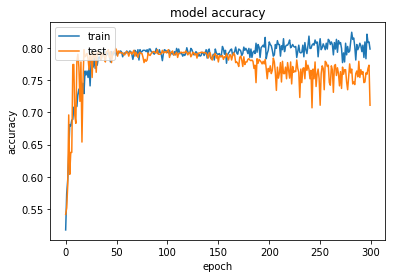

In [13]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

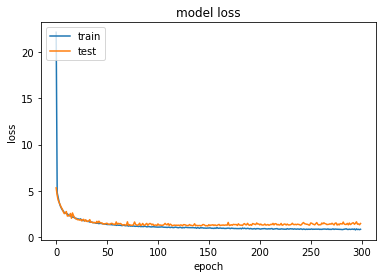

In [14]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
def baseline_model():
    model = Sequential()
    model.add(Dense(512, input_dim=max_len*max_width, activation='relu', activity_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='sigmoid', activity_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='sigmoid', activity_regularizer=l2(0.0005)))
    model.add(Dropout(0.1))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [17]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=32, verbose=0)

In [18]:
kfold = KFold(n_splits=10, shuffle=True)

## Average performance of the network

In [19]:
results = cross_val_score(estimator,np.array(new_circuit_arrays).reshape(num_circuits,max_len*max_width), validation_set, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 79.30% (4.70%)


# Distribution of circuits on different devices(real answers)

In [20]:
sum_vals = sum(validation_set)

In [21]:
dist_of_backends = {a.name():sum_vals[i] for i,a in enumerate(list_of_backends)}

Text(0.5,1,'Distribution of Circuits')

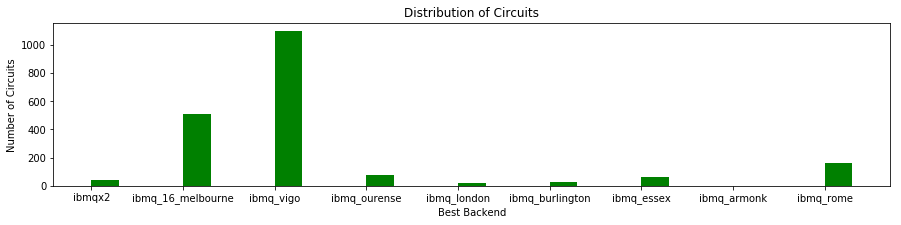

In [22]:
plt.figure(figsize=(15, 3))  # width:20, height:3
plt.bar(dist_of_backends.keys(),dist_of_backends.values(), align='edge', width=0.3, color="g")
plt.ylabel("Number of Circuits")
plt.xlabel("Best Backend")
plt.title("Distribution of Circuits")